# Baseline models

This section considers a number of different methods to predict if a subject has Alzheimer's disease (AD) or mild cognitive impairment (LMCI). The data used to construct the models is limited to ADNI 1 baseline observations. 

A wide range of methods are considered to determine if certain methods are more effective in predicting Alzheimer's diagnosis. The strategy to evaluate the performance of the different methods is two-fold: First a range of different models are fit on a set of 15 features from the ADNI merge dataset that are known to be important predictors. The best methods identified from this stage are then further investigated on the full set of features. 

In [1]:
# Core
import itertools
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from tqdm import tqdm
from IPython.display import Image
from IPython.display import display

# skcikit-learn
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

# UDF
from utils.helpers import GridSearchPipe

In [2]:
# ====================
# Settings
# ====================

# IPython
%matplotlib inline

# Seaborn
sns.set();
sns.set_context("talk");
sns.set_style("white");
sns.set_palette(sns.color_palette("Set1", n_colors=8, desat=.5));

# Pandas
pd.set_option('precision', 4)

# Warnings
import warnings
warnings.filterwarnings('ignore');

## Data processing

The first section includes a number of data processing steps to transform the pre-processed dataset with all the relevant features from the ADNI database such that different machine learning models can easily be fit on the data.

**Data processing steps**
* Data and metadata files are imported
* Observations are subset to only include baseline observations for ADNI 1 subjects
* Response and list of predictors to include in baseline model are specified
* Data is split into train and test datasets
* Predictors with missing values for more than 90% of observations are dropped
* Missing values are imputed using a k-means clustering approach (more detail below)
* Predictors are scaled to have zero mean and unit variance

**Training and validation approach**

The entire dataset with baseline observations for ADNI 1 subjects are split into a 70% training set with 30% of the data held out for validation and testing. Given the limited amount of observations (~800), we decided not keep a second test set to test out-of-sample performance on the final model although this would be have been ideal.

**Missing data strategy**

The strategy for dealing with missing data has several components. Firstly, the project design ensures consistency of coverage across the different features as we are only considering observations from a single collection protocol (i.e. ADNI 1) and issues with missing data over multiple visits are addressed by only considering baseline visits. The remaining missing observations in the base dataset is dealt with my either dropping the feature if it contains a very large proportion of missing values or using the k-means imputation approach. Excluding features with a very high proportion of missing values is reasonably as they are unlikely to add significant power to the models. The k-means imputation approach, builds on standard mean imputation by running a clustering algorithm on the features to group 'similar' observations together and then using the mean within each cluster rather than the overall mean.

**Standardizing predictors**

Predictors were standardized to have zero mean and unit variance so that methods that are not invariant to scale (e.g. SVM and Lasso Regression) could easily be compared on the same dataset.

**Baseline features**

The following 15 features included in ADNI merge datset that are known to be important predictors are considered in the simple baseline model:

* Risk factors: *AGE, PTEDUCAT, APOE4*
* Cognitive tests: *ADAS11, ADAS13, MMSE, RAVLT_immediate*
* MRI measures: *Ventricles, Hippocampus, WholeBrain, Entorhinal, Fusiform, MidTemp, ICV*
* Pet measures: *FDG*


In [3]:
# ====================
# Import data
# ====================

# Read data
data = pd.read_csv('../data/data_all.csv', low_memory=False);

# Create 'year' variable
data['YEAR'] = data['EXAMDATE'].apply(lambda x: x[:4])

# Subset data to baseline observations for ADNI 1
data = data.loc[(data['VISCODE'] == "bl") & (data['ORIGPROT'] == "ADNI1"), :]

# Import metadata file
meta = pd.read_csv('../data/metadata.csv')

In [4]:
# ======================
# Model data processing
# ======================

def get_model_data(data, response_col, model_cols):

    # Split into train and test datasets
    data_train, data_test = train_test_split(data, test_size=0.3, random_state=87)
    
    # Response data
    y_train, y_test = data_train[response_col], data_test[response_col]

    # Model predictors
    X_train, X_test = data_train[model_cols], data_test[model_cols]
    
    # Drop predictors with very high proportion (90%+) of missing values
    df = X_train.apply(lambda x: x.isnull().sum() / len(X_train))
    keep_cols = list(df[df<0.9].index)
    X_train = X_train[keep_cols]
    X_test = X_test[keep_cols]  
    
    # Method to impute missing values using k-means clustering
    def kmeans_missing(X, n_clusters, max_iter=10):

        # Initialize missing values to their column means
        missing = ~np.isfinite(X)
        mu = np.nanmean(X, 0, keepdims=1)
        X_hat = np.where(missing, mu, X)

        for i in range(max_iter):
            if i > 0:
                cls = KMeans(n_clusters, init=prev_centroids)
            else:
                cls = KMeans(n_clusters, n_jobs=-1)

            # Perform clustering on the filled-in data
            labels = cls.fit_predict(X_hat)
            centroids = cls.cluster_centers_

            # Fill in the missing values based on their cluster centroids
            X_hat[missing] = centroids[labels][missing]

            # When the labels have stopped changing then we have converged
            if i > 0 and np.all(labels == prev_labels):
                break

            prev_labels = labels
            prev_centroids = cls.cluster_centers_

        return X_hat
    
    # Proportion of features with missing values by observation
    X_train['Proportion_missing'] = X_train.isnull().sum(axis=1) / X_train.shape[1]
    X_test['Proportion_missing'] = X_test.isnull().sum(axis=1) / X_test.shape[1]

    # Update model_cols list
    model_cols = list(X_train.columns)

    # Missing value imputation
    X_train = kmeans_missing(X_train, n_clusters=10)
    X_test = kmeans_missing(X_test, n_clusters=10)

    check = np.isnan(X_train).sum() + np.isnan(X_test).sum()
    if check != 0:
        raise ValueError("Missing values in train/test data.")
        
    # Standardize predictors
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, model_cols

In [5]:
# Response column name
response_col = "DX_bl"
class_names = ['CN','LMCI','AD']

# Create list of baseline predictors from metadata
model_cols = list(meta.loc[meta.baseline==1,'column_name'])

# Model data processing
X_train, X_test, y_train, y_test, model_cols = get_model_data(data, response_col, model_cols)

## Baseline Logistic Regression model

First a simple Logistic Regression model is fit using the 15 baseline features identified above. The purpose of this model is to provide some initial understanding of the type of accuracy that can be achieved using a small number of features that are expected to be important and a standard modelling method. Some diagnostics are also produced to identify the most important features in the model.

In [6]:
# =========================================
# Fit regularized Logistic Regression model
# =========================================

# Fit model
clf = LogisticRegressionCV(Cs=20, cv=5, penalty='l2')
clf.fit(X_train, y_train);

# Fit OvR classifier
y = label_binarize(y_train, classes=class_names) 
ovr = OneVsRestClassifier(clf)
ovr.fit(X_train, y)  

# Confusion matrix
y_pred = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

# Train/test accuracy
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

In [7]:
# Method to plot cross-validation results
def plot_cv_results(clf, ax):
    
    mu = [np.mean(v, axis=0) for k, v in clf.scores_.items()]
    sd = [np.std(v, axis=0) for k, v in clf.scores_.items()]
     
    i = 0
    for c in clf.classes_:
        ax.plot(np.log(clf.Cs_), mu[i], label=c)
        ax.fill_between(np.log(clf.Cs_), mu[i]-sd[i], mu[i]+sd[i], alpha=0.3)
        i += 1

    ax.set_ylabel('Validation accuracy', fontsize=14)
    ax.set_xlabel('Regularization parameter', fontsize=14)
    ax.set_title('Cross-validation', fontsize=16)
    ax.legend();

In [8]:
# Method to plot ROC chart
def plot_roc(ovr, X_test, y_test, ax, title):

    y = label_binarize(y_test, classes=['CN','LMCI','AD']) 
    y_score = ovr.predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    n_classes = len(clf.classes_)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve
    ax.plot(fpr["micro"], tpr["micro"],
             label='Average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))

    for i,label in zip(range(n_classes),['CN','LMCI','AD']):
        ax.plot(fpr[i], tpr[i], label='ROC curve of class {0} ({1}) (area = {2:0.2f})'
                                       ''.format(i,label, roc_auc[i]));

    ax.plot([0, 1], [0, 1], 'k--');
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right");


In [9]:
def plot_confusion_matrix(cm, classes, ax, title,
                          normalize=False, 
                          cmap=plt.cm.GnBu):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    ax.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

In [10]:
def plot_important_features(clf, X, y, model_cols, ax, title, nsims=100, top_n=10):

    n, p = X.shape
    importance_scores = np.empty((nsims, p))

    for i in range(nsims):
        # Randomize observations for predictor i
        sample = np.random.randint(0,n-1, n)
        
        for j in range(p):
            
            # Get initial score
            s1 = clf.score(X, y)

            # Randomize
            X_rand = X.copy()
            X_rand[:,j] = X_rand[sample, j]

            # Get new score
            s2 = clf.score(X_rand, y)
            importance_scores[i,j] = s1 - s2
       
    df = pd.DataFrame(np.mean(importance_scores, axis=0))
    df.index = model_cols
    df.columns = ["FactorInfluence"]
    df.sort_values(by="FactorInfluence", ascending=True, inplace=True)
    df = df[-top_n:]
    df[df < 0] = 0
    df.plot(kind='barh', ax=ax, legend=False)
    ax.set_title(title)

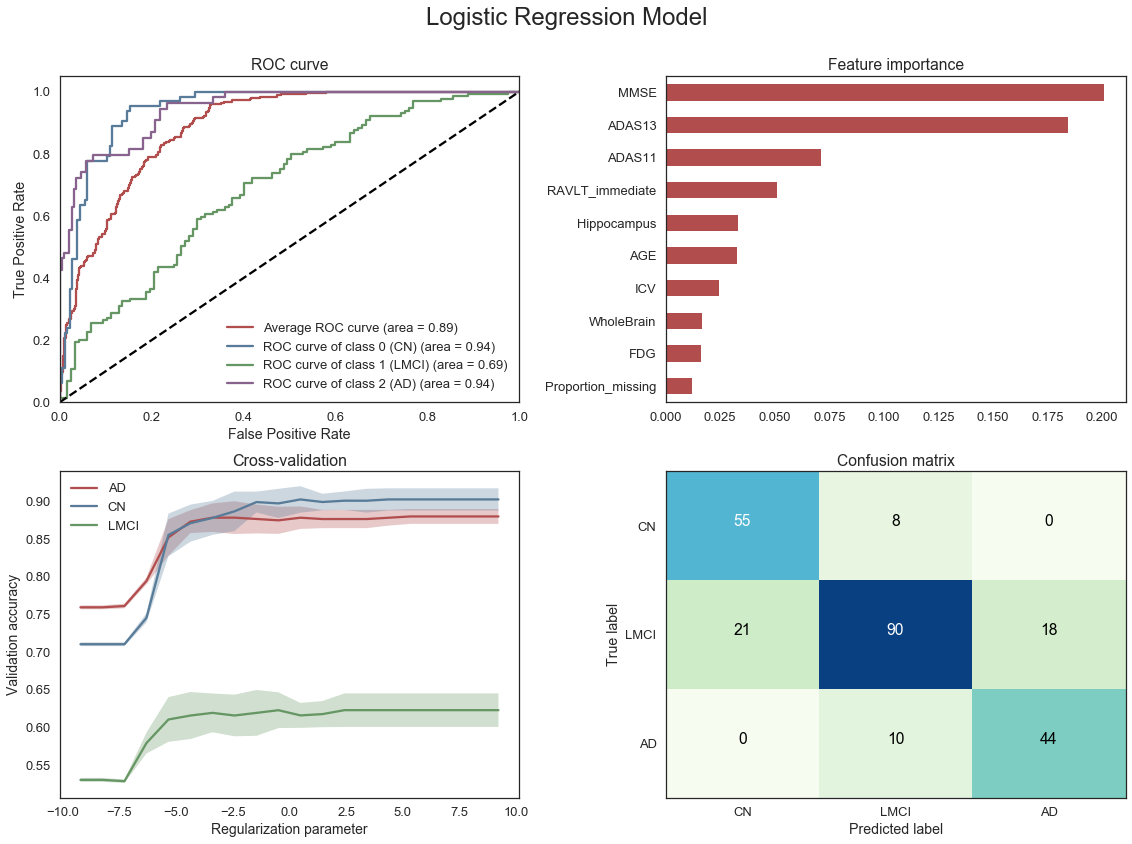

In [11]:
# =================
# Model diagnostics
# =================

title = "Logistic Regression Model"
    
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
ax = ax.ravel()

# Title
plt.suptitle(title, fontsize=24)  
plt.tight_layout()

# ROC plot
plot_roc(ovr, X_test, y_test, ax[0], title="ROC curve")

# Factor importance
plot_important_features(clf, X_test, y_test,
                        model_cols, ax=ax[1], title="Feature importance", 
                        nsims=100, top_n=10)

# Regularization 
plot_cv_results(clf, ax[2]) 

# Confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names, ax=ax[3],
                     title='Confusion matrix')

plt.subplots_adjust(top=0.90)
plt.show()

From the diagnostics above we note that the Logistic regression model is able to achieve an average area under the curve (AUC) of 0.88. The model is reasonably effective at correctly identifying true Cognitively Normal (CN) and Alzheimer's (AD) patients with a fair amount of uncertainty when classifying subjects with Mild Cognitive Impairment (LMCI). The most important features are the cognitive tests followed by some of the MRI measures.

## Comparison of different classification methods for baseline model

Next a number of different methods are evaluated on the same set of features used to create the Logistic Regression model above. The following methods are considered with some basic parameter tuning using 10-fold cross validation

* Logistic Regression 
* Ridge Regression
* Elastic Net
* K-Nearest Neighbors (KNN)
* Linear Discriminant Analysis (LDA)
* Quadratic Discriminant Analysis (QDA)
* AdaBoost
* Gradient Boosting Method (GBM)
* Support Vector Machines (SVC)

The Elastic Net method was not covered directly in the course. It is a regularized regression method with a penalty term based on weighted L1 and L2 norms. It is therefore effectively weighting the Lasso and Ridge regression methods with the optimal weight determined through cross-validation.

In [12]:
# =========================
# Fit classification models
# =========================

# Estimators
models = {'LogisticRegression': LogisticRegressionCV(), 
          'RidgeRegression': RidgeClassifierCV(alphas=(0.01, 0.1, 1, 10, 100)),
          'ElasticNet': SGDClassifier(penalty='elasticnet'),
          'KNN': KNeighborsClassifier(),
          'LDA': LDA(), 
          'QDA': QDA(),
          'RF': RandomForestClassifier(),
          'AdaBoost': AdaBoostClassifier(),
          'GBM': GradientBoostingClassifier(),
          'SVC': SVC(probability=True)
}

# Parameters
params = {'LogisticRegression': {},
          
          'RidgeRegression': {},
          
          'ElasticNet': 
                        {'l1_ratio': [0.2, 0.5, 0.8]},
          'KNN': 
                        {'n_neighbors': [3, 5, 7, 13]},
          'LDA': {},
          
          'QDA': {},
          
          'RF': 
                        {'n_estimators': [10, 20, 50, 100, 500]},
          'AdaBoost': 
                        {'n_estimators': [50, 100, 200]},
          'GBM': 
                        {'learning_rate': [0.05, 0.1, 0.2], 'n_estimators': [50, 100, 200]},
          'SVC': [
                        {'kernel': ['linear'], 'C': [1, 10]},
                        {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]}
                ]
}

# Grid search
gsp = GridSearchPipe(models, params)
gsp.fit(X_train, y_train, cv=10, n_jobs=4, refit=True, verbose=0)
res = gsp.score_summary()
res[:10]

,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,l1_ratio,learning_rate,n_estimators,n_neighbors
13,RF,0.7143,0.7834,0.8621,0.0485,-,-,-,-,-,50,-
19,GBM,0.7321,0.7800,0.8621,0.0439,-,-,-,-,0.05,50,-
28,SVC,0.6724,0.7784,0.8621,0.0580,1,-,linear,-,-,-,-
9,LDA,0.6724,0.7764,0.8966,0.0621,-,-,-,-,-,-,-
29,SVC,0.6724,0.7715,0.8621,0.0586,10,-,linear,-,-,-,-
14,RF,0.6964,0.7711,0.8621,0.0416,-,-,-,-,-,100,-
15,RF,0.6786,0.7711,0.8793,0.0606,-,-,-,-,-,500,-
0,LogisticRegression,0.6552,0.7697,0.9138,0.0707,-,-,-,-,-,-,-
12,RF,0.7143,0.7662,0.8182,0.0367,-,-,-,-,-,20,-
20,GBM,0.6491,0.7660,0.8448,0.0577,-,-,-,-,0.05,100,-


The table above ranks the methods with relevant hyper-parameters by mean validation accuracy. We note that the mean accuracy based on a 10-fold cross-validation of the first 5-6 models are very similar. 

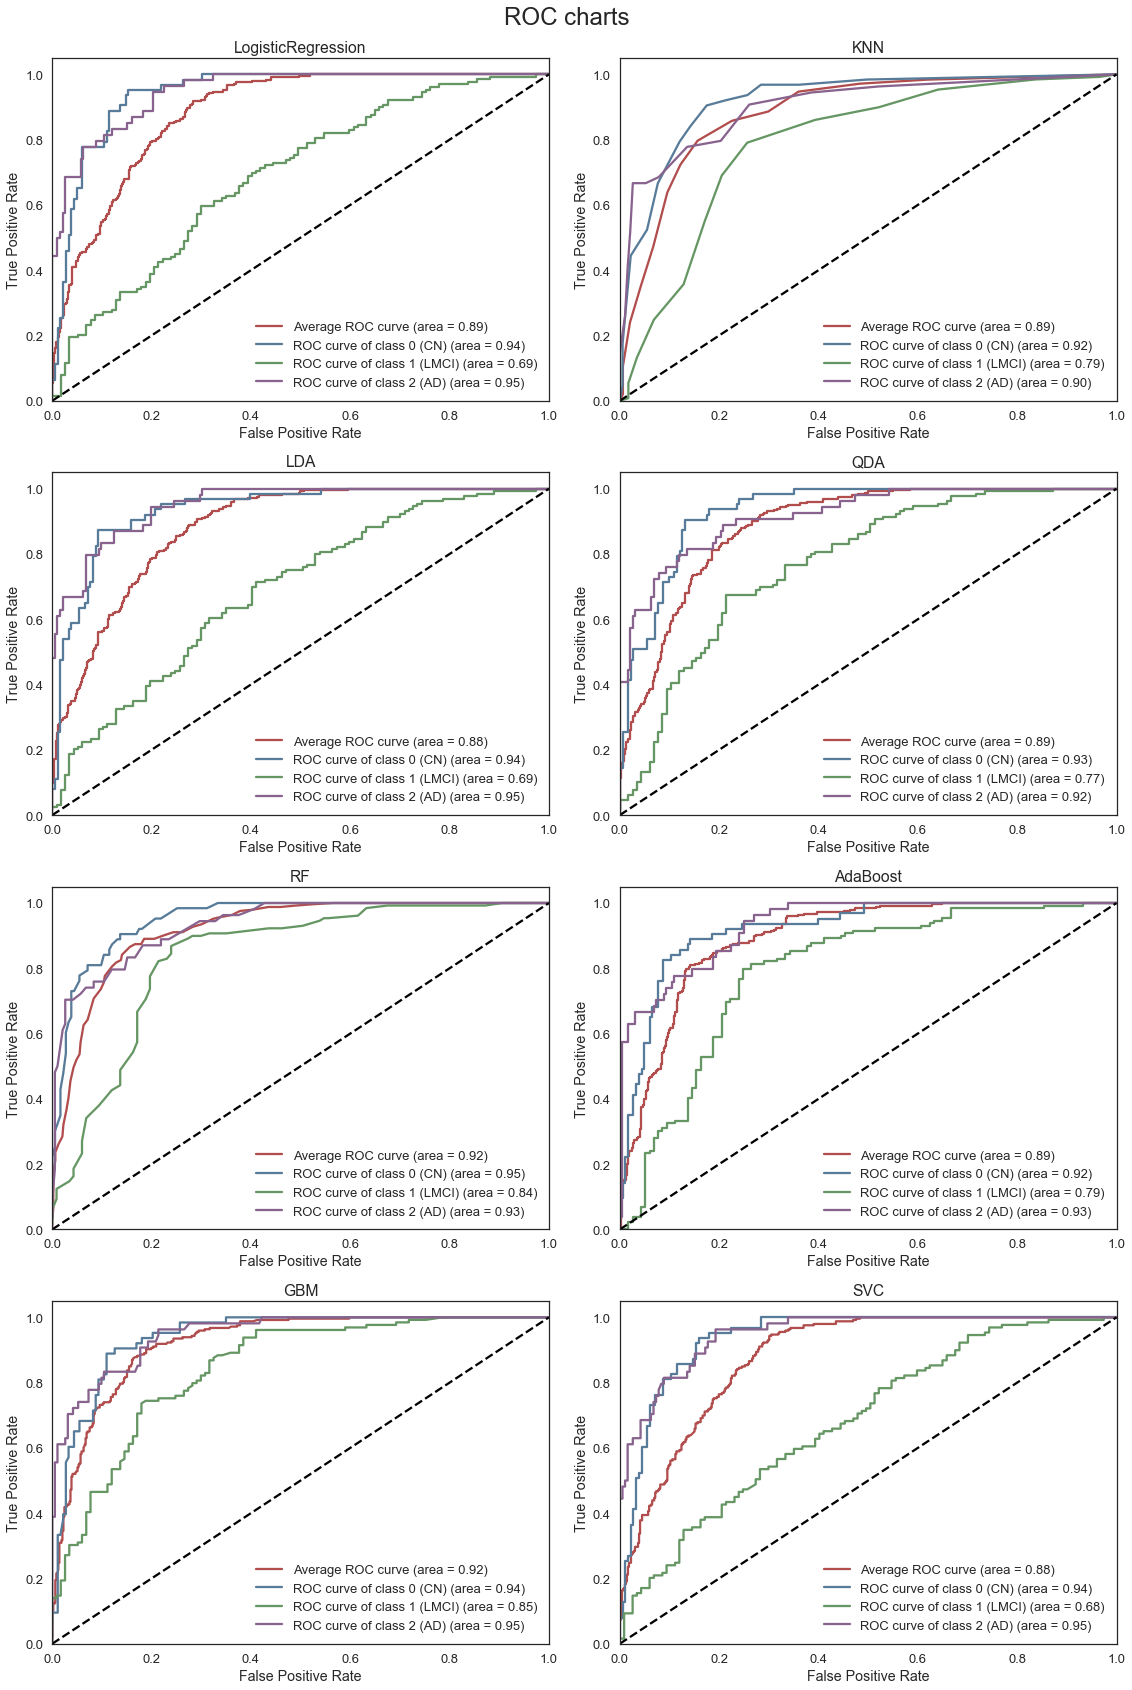

In [13]:
# =================
# Model diagnostics
# =================

#
# ROC curves
#

fig, ax = plt.subplots(4, 2, figsize=(16, 24))
ax = ax.ravel()

i = 0
for mod in models.keys():
    
    # Get model
    clf = gsp.get_best_estimator(mod)
    
    # Fit OvR classifier
    y = label_binarize(y_train, classes=class_names) 
    ovr = OneVsRestClassifier(clf)
    ovr.fit(X_train, y)  
    try:
        p = len(ovr.predict_proba(X_train)) 
    except:
        p = 0

    if p > 0:
        plot_roc(ovr, X_test, y_test, ax[i], title=mod) 
        i = i + 1
        
plt.tight_layout()  
plt.suptitle("ROC charts", fontsize=24)
plt.subplots_adjust(top=0.95)
plt.show()

The ROC curves above, describe the trade-off between the True positive rate (TPR) and False Positive Rate (FPR) for each of the models. Models with a higher area under the curve (AUC) or high True Positive Rate for a given False Positive Rate are generally preferred. We note that the RF and GBM models are able to most accurately classify subjects accross all three classes. Although the mean validation accuracy of the LDA model is comparable to the RF and GBM models, the average AUC is lower as the LDA model is less effective at classifying subjects with LMCI.

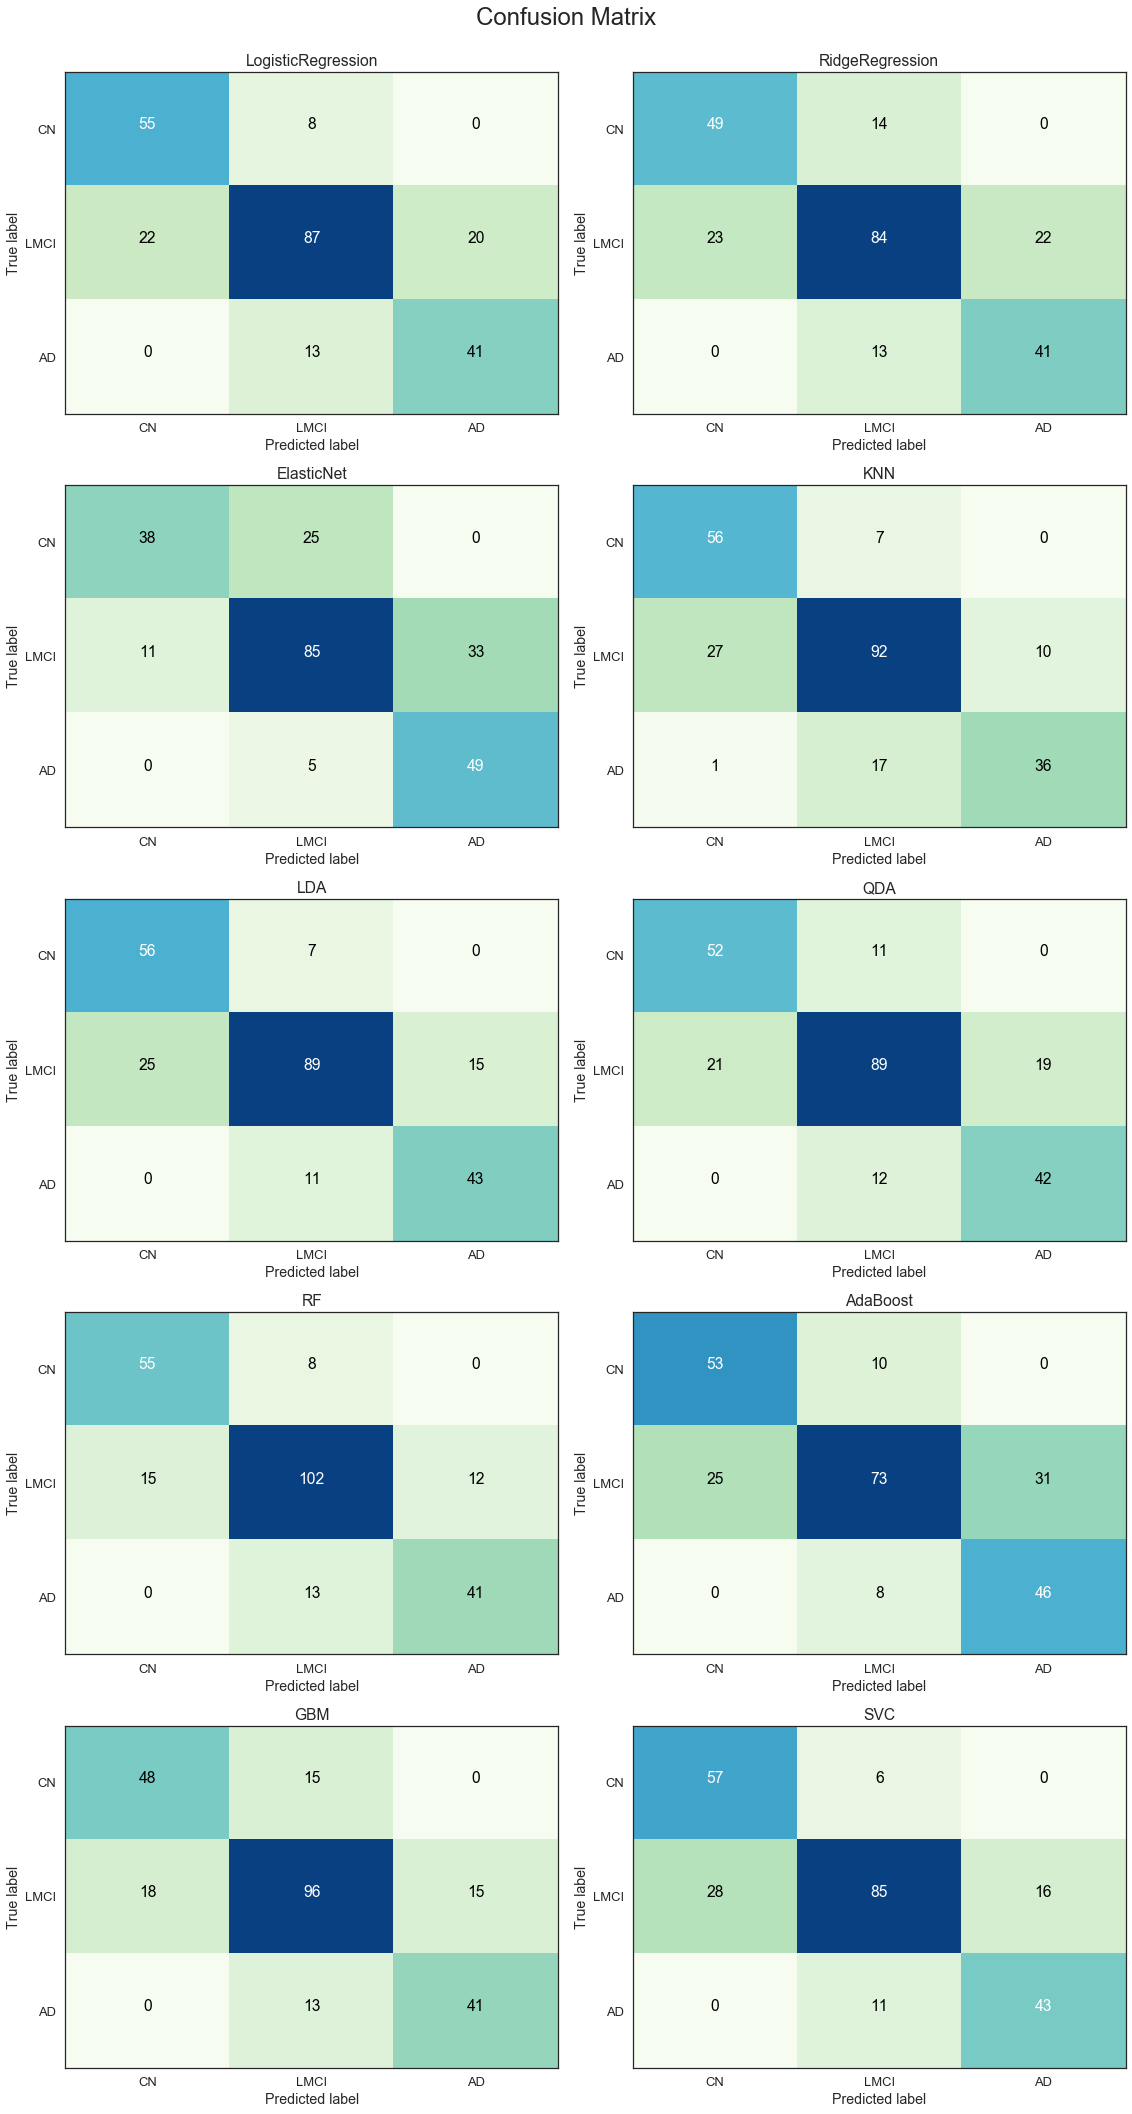

In [14]:
#
# Confusion matrix
#

fig, ax = plt.subplots(5, 2, figsize=(16, 30))
ax = ax.ravel()

i = 0
for mod in models.keys():
    
    # Get model
    clf = gsp.get_best_estimator(mod)
    
    # Confusion matrix
    y_pred = clf.predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

    # Plot
    plot_confusion_matrix(cnf_matrix, classes=class_names, ax=ax[i], title=mod)
    i = i + 1
        
plt.tight_layout()  
plt.suptitle("Confusion Matrix", fontsize=24)
plt.subplots_adjust(top=0.95)
plt.show()

The results from the confusion matrices are consistent with the observations from the ROC curves. The RF and GBM models are the best performers across all three classes on average.

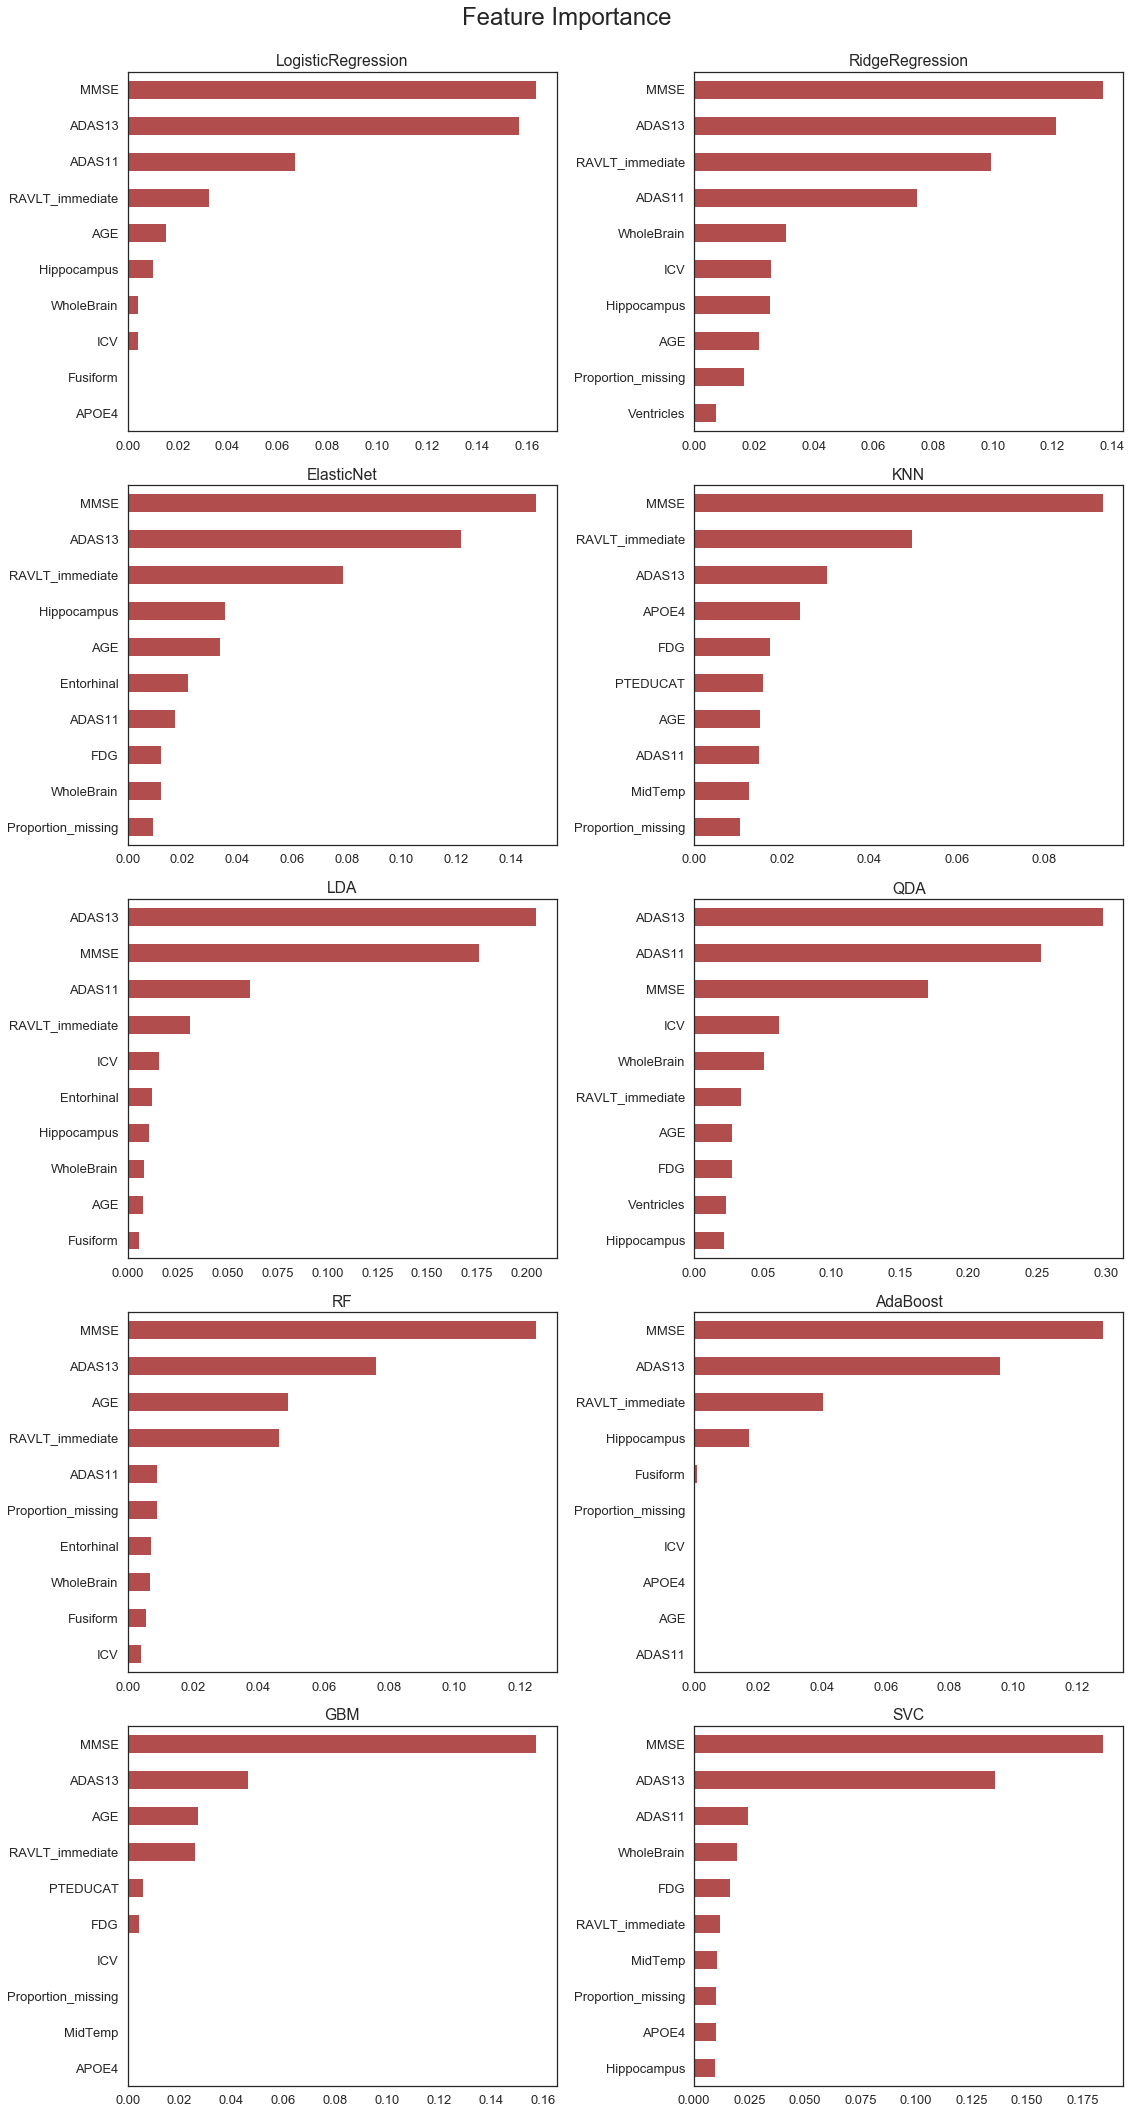

In [15]:
#
# Feature Importance
#

fig, ax = plt.subplots(5, 2, figsize=(16, 30))
ax = ax.ravel()

i = 0
for mod in models.keys():
    
    # Get model
    clf = gsp.get_best_estimator(mod)
    
    # Factor importance
    plot_important_features(clf, X_test, y_test,
                            model_cols, ax=ax[i], title=mod,
                            nsims=100, top_n=10)
    i = i + 1
        
plt.tight_layout()  
plt.suptitle("Feature Importance", fontsize=24)
plt.subplots_adjust(top=0.95)
plt.show()

The feature importance plots provide a measure of the relative importance of each of the features included in the model. The plots consistently show that the cognitive tests are the most important features included in the models.

Feature importance measures are typically available for tree-based methods. A bespoke measure was created to compare the importance of features in different model types. The measure is obtained by quantifying the reduction in accuracy after a random shuffle of the obervations for a specific feature. The intuition is that accuracy should reduce significantly for an important feature whereas the effect will be limited for unimportant (random) features. This method would be too computationally intensive for large models with many observations and predictors, but is fit for this exercise.

## More parameter tuning for GBM and SVC methods

In this section we conduct more detailed testing of the GBM and SVC methods considering a wider range of model paramters, optimized using cross-validation.

In [16]:
# ======================
# Parameter tuning
# ======================

# Estimators
models = {'GBM': GradientBoostingClassifier(),
          'SVC': SVC(probability=True)
}

C_range = np.logspace(-2, 2, 5)
gamma_range = np.logspace(-1, 1, 3)

# Parameters
params = {'GBM':  {'learning_rate': [0.01, 0.05, 0.1, 0.2], 
                   'n_estimators': [50, 100, 200, 500],
                   'subsample': [0.5, 0.7, 1],
                   'max_depth': [3, 5]},
          'SVC': [
                   {'kernel': ['linear'], 'C': C_range, 'gamma': gamma_range},
                   {'kernel': ['rbf'], 'C': C_range, 'gamma': gamma_range},
                   {'kernel': ['poly'], 'C': C_range, 'gamma': gamma_range, 'degree': [2, 3]}
                ]
}

# Grid search
gsp = GridSearchPipe(models, params)
gsp.fit(X_train, y_train, cv=10, n_jobs=4, refit=True, verbose=0)
res = gsp.score_summary()
res[:10]

,estimator,min_score,mean_score,max_score,std_score,C,degree,gamma,kernel,learning_rate,max_depth,n_estimators,subsample
88,GBM,0.7143,0.7872,0.8793,0.0536,-,-,-,-,0.2,5,100,0.7
33,GBM,0.7368,0.7853,0.9138,0.0564,-,-,-,-,0.05,3,500,0.5
8,GBM,0.7321,0.7835,0.8621,0.0451,-,-,-,-,0.01,3,200,1
14,GBM,0.7241,0.7820,0.8448,0.0341,-,-,-,-,0.01,5,50,1
24,GBM,0.7018,0.7819,0.8621,0.0477,-,-,-,-,0.05,3,50,0.5
5,GBM,0.6897,0.7819,0.8793,0.0555,-,-,-,-,0.01,3,100,1
25,GBM,0.7069,0.7818,0.8772,0.0536,-,-,-,-,0.05,3,50,0.7
12,GBM,0.7193,0.7801,0.8793,0.0467,-,-,-,-,0.01,5,50,0.5
27,GBM,0.6667,0.7800,0.8947,0.0623,-,-,-,-,0.05,3,100,0.5
7,GBM,0.7193,0.7800,0.8793,0.0446,-,-,-,-,0.01,3,200,0.7


Mean validation accuracy is slightly improved after extensive parameter tuning.

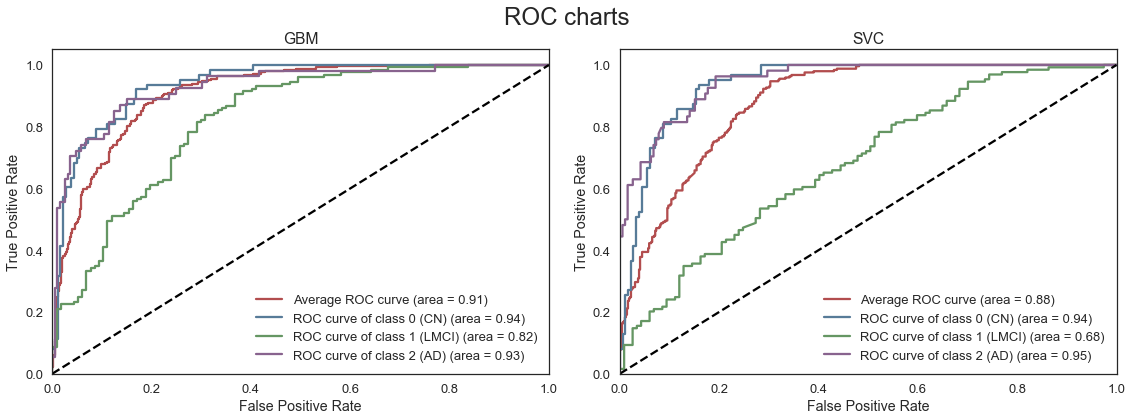

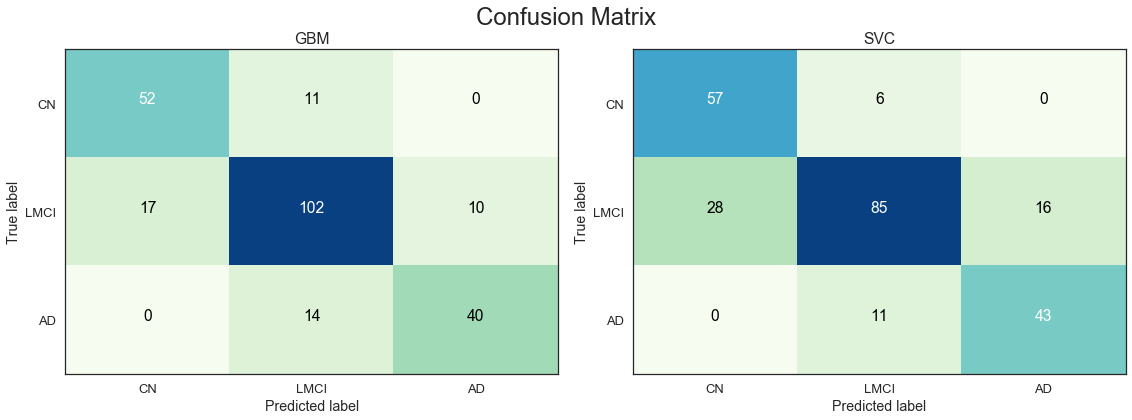

In [17]:
# =================
# Model diagnostics
# =================

#
# ROC
#

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax = ax.ravel()

i = 0
for mod in models.keys():
    
    # Get model
    clf = gsp.get_best_estimator(mod)
    
    # Fit OvR classifier
    y = label_binarize(y_train, classes=class_names) 
    ovr = OneVsRestClassifier(clf)
    ovr.fit(X_train, y)  
    try:
        p = len(ovr.predict_proba(X_train)) 
    except:
        p = 0

    if p > 0:
        plot_roc(ovr, X_test, y_test, ax[i], title=mod) 
        i = i + 1
        
plt.tight_layout()  
plt.suptitle("ROC charts", fontsize=24)
plt.subplots_adjust(top=0.88)
plt.show()

#
# Confusion matrix
#

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax = ax.ravel()

i = 0
for mod in models.keys():
    
    # Get model
    clf = gsp.get_best_estimator(mod)
    
    # Confusion matrix
    y_pred = clf.predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

    # Plot
    plot_confusion_matrix(cnf_matrix, classes=class_names, ax=ax[i], title=mod)
    i = i + 1
        
plt.tight_layout()  
plt.suptitle("Confusion Matrix", fontsize=24)
plt.subplots_adjust(top=0.88)
plt.show()

## Full model with all features

Further analysis of the GBM and SVC models based on the full set of predictors.

In [18]:
# ===============
# Data processing
# ===============

# Response column name
response_col = "DX_bl"
class_names = ['CN','LMCI','AD']

# Create list of baseline predictors from metadata
model_cols = list(meta.loc[meta.baseline==1,'column_name'])

# Sources in addition to baseline
source_list = ['NEUROBAT', 'UCSFFSX', 'UPENNBIOMK9', 'ADASSCORES', 'PTDEMOG', 'FHQ', 'FHQ', 'TOMM40']
model_cols = model_cols + list(meta[meta['source'].isin(source_list)]['column_name'])

# Model data processing
X_train, X_test, y_train, y_test, model_cols = get_model_data(data, response_col, model_cols)


In [19]:
# ====================================
# Fit model (GradientBoosting and SVC)
# ====================================

# Estimators
models = {'GBM': GradientBoostingClassifier(),
          'SVC': SVC(probability=True)
}

C_range = np.logspace(-2, 2, 5)
gamma_range = np.logspace(-2, 2, 5)

# Parameters
params = {'GBM':  {'learning_rate': [0.01, 0.05, 0.1], 
                   'n_estimators': [200, 500],
                   'subsample': [0.5, 1],
                   'max_depth': [3, 5]},
          'SVC': [
                   {'kernel': ['linear'], 'C': C_range, 'gamma': gamma_range},
                   {'kernel': ['rbf'], 'C': C_range, 'gamma': gamma_range},
                   {'kernel': ['poly'], 'C': C_range, 'gamma': gamma_range, 'degree': [2, 3]}
                ]
}

# Grid search
gsp = GridSearchPipe(models, params)
gsp.fit(X_train, y_train, cv=10, n_jobs=4, refit=True, verbose=0)
res = gsp.score_summary()
res[:10]

,estimator,min_score,mean_score,max_score,std_score,C,degree,gamma,kernel,learning_rate,max_depth,n_estimators,subsample
2,GBM,0.7018,0.7956,0.8966,0.0523,-,-,-,-,0.01,3,500,0.5
15,GBM,0.7368,0.7938,0.8966,0.0468,-,-,-,-,0.05,5,500,1
13,GBM,0.7414,0.7937,0.8793,0.0424,-,-,-,-,0.05,5,200,1
4,GBM,0.6842,0.7923,0.8966,0.0663,-,-,-,-,0.01,5,200,0.5
21,GBM,0.7091,0.7919,0.8621,0.0482,-,-,-,-,0.1,5,200,1
6,GBM,0.6842,0.7904,0.8793,0.0512,-,-,-,-,0.01,5,500,0.5
12,GBM,0.7018,0.7887,0.8793,0.0531,-,-,-,-,0.05,5,200,0.5
19,GBM,0.7241,0.7871,0.8276,0.0342,-,-,-,-,0.1,3,500,1
20,GBM,0.7193,0.7871,0.8421,0.0347,-,-,-,-,0.1,5,200,0.5
11,GBM,0.7368,0.7870,0.8596,0.0373,-,-,-,-,0.05,3,500,1


The table above ranks the best models by mean validation score on the full set of features. We note that the mean accuracy has only improved marginally compared to the smaller set of predictors. This is to some extent expected given the significance of the cognitive test scores, which are all included in the smaller set of predictors. The key MRI and PET measures are also included in the smaller set of predictors. The 400+ additional predictors appears to only include limited additional information, while increasing the dimensionality of the feature space significantly. We note that the GBM model appears to deal better with the large number of predictors that the SVC model.

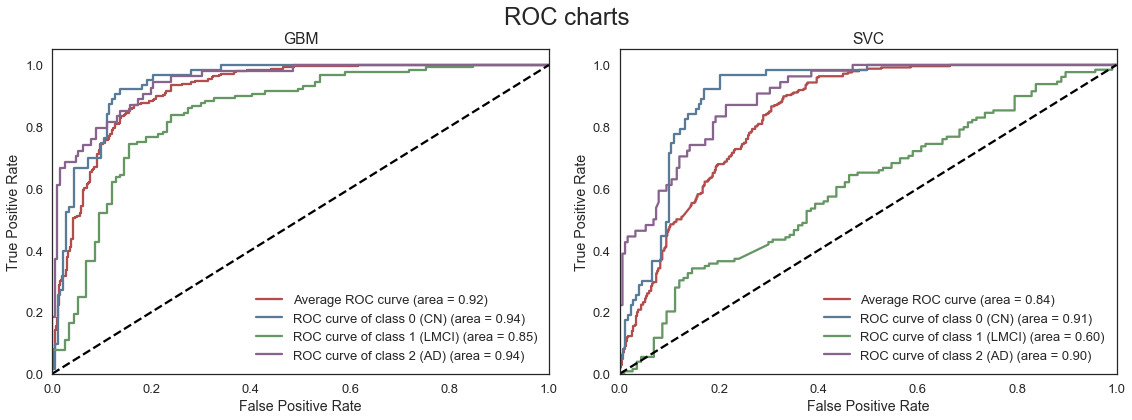

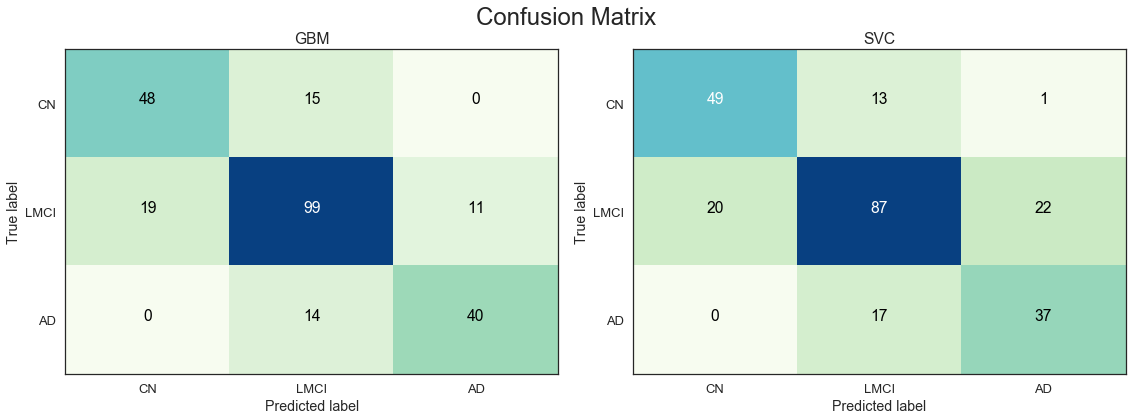

In [20]:
# =================
# Model diagnostics
# =================

#
# ROC
#

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax = ax.ravel()

i = 0
for mod in models.keys():
    
    # Get model
    clf = gsp.get_best_estimator(mod)
    
    # Fit OvR classifier
    y = label_binarize(y_train, classes=class_names) 
    ovr = OneVsRestClassifier(clf)
    ovr.fit(X_train, y)  
    try:
        p = len(ovr.predict_proba(X_train)) 
    except:
        p = 0

    if p > 0:
        plot_roc(ovr, X_test, y_test, ax[i], title=mod) 
        i = i + 1
        
plt.tight_layout()  
plt.suptitle("ROC charts", fontsize=24)
plt.subplots_adjust(top=0.88)
plt.show()

#
# Confusion matrix
#

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax = ax.ravel()

i = 0
for mod in models.keys():
    
    # Get model
    clf = gsp.get_best_estimator(mod)
    
    # Confusion matrix
    y_pred = clf.predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

    # Plot
    plot_confusion_matrix(cnf_matrix, classes=class_names, ax=ax[i], title=mod)
    i = i + 1
        
plt.tight_layout()  
plt.suptitle("Confusion Matrix", fontsize=24)
plt.subplots_adjust(top=0.88)
plt.show()

The GBM model appears to have the best predictive performance on the full feature. 

## XGBoost model

In this section another boosted model is fit using the XGBoost package, that was designed and optimized for boosting trees algorithm. The underlying algorithm of XGBoost is an extension of the classic gradient boosting algorithm. Some of the strenghts of this implementation compared to scikit-learn includes:

**Regularization:** The algorithm allows for regularization of weights through the `lambda` and `alpha` parameters, which helps to reduce over-fitting.

**Parallel computing:** XGBoost implements parallel processing making it significantly faster on large datasets

**Tree pruning:** In GBM, a greed algortihm is used that would only stop splitting a node when it encounters a negative loss in the split. XGBoost makes splits up to the maximum depth specified and then prunes the tree backwards to remove redundant splits

In [21]:
# ===================
# Fit model (XGBoost)
# ===================

# Response
yint_train = [class_names.index(y) for y in y_train]
yint_test = [class_names.index(y) for y in y_test]

# XGBoost data structure
xg_train = xgb.DMatrix(X_train, label=yint_train)
xg_test = xgb.DMatrix(X_test, label=yint_test)

# Estimators

cparams = {'objective':'multi:softmax', 'num_class': 3, 'n_jobs':-1}
models = {'XGBoost': xgb.XGBClassifier(**cparams)}

# Parameters
params = {'XGBoost':  {'learning_rate': [0.1], 
                       'n_estimators': [500],
                       'subsample': [0.5, 1],
                       'colsample_bytree': [0.8, 1],
                       'max_depth': [3, 5, 7],
                       'reg_alpha': [0, 0.1, 0.2]}
         }

# # Grid search
gsp = GridSearchPipe(models, params)
gsp.fit(X_train, y_train, cv=5, n_jobs=-1, refit=True, verbose=0)
res = gsp.score_summary()
res[:10]

,estimator,min_score,mean_score,max_score,std_score,colsample_bytree,learning_rate,max_depth,n_estimators,reg_alpha,subsample
28,XGBoost,0.7456,0.7817,0.8348,0.0399,1.0,0.1,5,500,0.2,0.5
35,XGBoost,0.7522,0.7783,0.8000,0.0191,1.0,0.1,7,500,0.2,1.0
34,XGBoost,0.7281,0.7766,0.8261,0.0394,1.0,0.1,7,500,0.2,0.5
10,XGBoost,0.7434,0.7765,0.8174,0.0306,0.8,0.1,5,500,0.2,0.5
26,XGBoost,0.7456,0.7748,0.8087,0.0224,1.0,0.1,5,500,0.1,0.5
13,XGBoost,0.7257,0.7747,0.8000,0.0272,0.8,0.1,7,500,0.0,1.0
12,XGBoost,0.7368,0.7731,0.8000,0.0220,0.8,0.1,7,500,0.0,0.5
15,XGBoost,0.7434,0.7730,0.8087,0.0262,0.8,0.1,7,500,0.1,1.0
14,XGBoost,0.7193,0.7730,0.8348,0.0449,0.8,0.1,7,500,0.1,0.5
24,XGBoost,0.7105,0.7729,0.8348,0.0445,1.0,0.1,5,500,0.0,0.5


In [22]:
# Parameters based on Gridsearch results 
clf = xgb.XGBClassifier(max_depth = 7,
                        n_estimators=1000,
                        learning_rate=0.01, 
                        objective='multi:softmax',
                        num_class=3,
                        n_jobs=-1,
                        subsample=0.5,
                        colsample_bytree=0.8,
                        reg_alpha=0.1)

# Get parameters
xgb_params = clf.get_xgb_params()

# Find best number of trees using CV
bst = xgb.cv(xgb_params, 
             dtrain=xg_train, 
             num_boost_round=3000, 
             nfold=5, 
             metrics=['merror'],
             early_stopping_rounds=100, 
             verbose_eval = False)

# Set number of trees and re-fit model
clf.set_params(n_estimators=bst.shape
               
# Get test accuracy
score = clf.score(X_test, y_test)
print("Test accuracy: {0:.2f}".format(score))

Test accuracy: 0.78


After determining the optimal parameters of the XGBoost model through cross-validation, the test performance of the model is very comparable to that obtained by the Gradient Boosting model. We note that XGBoost appears to be more computationally efficient, with quicker model fitting and better parallel performance.